In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DiscretizeTools import rouwenhorst, grow_grid
from scipy.optimize import root
from linear import LinintGrow
import time
import math as m
from joblib import Parallel, delayed

In [2]:
class LifeCycleFemale:
    
    '''
    This class specifies the life cycle model with female participation choice
    '''
    
    def __init__(self,
                γ = 0.5, β = 0.98, r = 0.04, wm = 1.0, wf = 0.75, J = 80, JR = 45,
                NP = 2, NS = 5, NA = 81, NH = 61, ν = 0.12, σθ = 0.242, σϵ = 0.022,
                ρ = 0.985, al = 0, au = 450, agrow = 0.05,
                ξ = [0.05312, -0.00188], δh = 0.074, hgrow = 0.03, hl =0,
                children = np.concatenate(([30,32], np.zeros(8))), verbose = True,
                ψ = np.array([1.00000, 0.99923, 0.99914, 0.99914, 0.99912, \
                0.99906, 0.99908, 0.99906, 0.99907, 0.99901, \
                0.99899, 0.99896, 0.99893, 0.99890, 0.99887, \
                0.99886, 0.99878, 0.99871, 0.99862, 0.99853, \
                0.99841, 0.99835, 0.99819, 0.99801, 0.99785, \
                0.99757, 0.99735, 0.99701, 0.99676, 0.99650, \
                0.99614, 0.99581, 0.99555, 0.99503, 0.99471, \
                0.99435, 0.99393, 0.99343, 0.99294, 0.99237, \
                0.99190, 0.99137, 0.99085, 0.99000, 0.98871, \
                0.98871, 0.98721, 0.98612, 0.98462, 0.98376, \
                0.98226, 0.98062, 0.97908, 0.97682, 0.97514, \
                0.97250, 0.96925, 0.96710, 0.96330, 0.95965, \
                0.95619, 0.95115, 0.94677, 0.93987, 0.93445, \
                0.92717, 0.91872, 0.91006, 0.90036, 0.88744, \
                0.87539, 0.85936, 0.84996, 0.82889, 0.81469, \
                0.79705, 0.78081, 0.76174, 0.74195, 0.72155, \
                0.00000]),
                eff = np.array([1.0000, 1.0719, 1.1438, 1.2158, 1.2842, 1.3527, \
                1.4212, 1.4897, 1.5582, 1.6267, 1.6952, 1.7217, \
                1.7438, 1.7748, 1.8014, 1.8279, 1.8545, 1.8810, \
                1.9075, 1.9341, 1.9606, 1.9623, 1.9640, 1.9658, \
                1.9675, 1.9692, 1.9709, 1.9726, 1.9743, 1.9760, \
                1.9777, 1.9700, 1.9623, 1.9546, 1.9469, 1.9392, \
                1.9315, 1.9238, 1.9161, 1.9084, 1.9007, 1.8354, \
                1.7701, 1.7048])):
        
        self.γ, self.β, self.ν, self.r, self.wm, self.wf, self.ψ = γ, β, ν, r, wm, wf, ψ
        self.J, self.JR, self.NA, self.NP, self.NS, self.NH = J, JR, NA, NP, NS, NH
        self.egam, self.children, self.verbose = 1-1/γ, children, verbose
        self.al, self.au, self.agrow, self.hl, self.hgrow, self.ξ, self.δh  = al, au, agrow, hl, hgrow, ξ, δh
        self.ρ, self.σθ, self.σϵ = ρ, σθ, σϵ
        
        # asset grid
        self.a = grow_grid(al, au, agrow, NA)
        
        # surving probability and labor efficiency and pensions
        self.eff = np.concatenate((eff, np.zeros(J - JR +1)))
        self.pen = np.concatenate((np.zeros(JR-1), np.ones(J-JR+1)*(0.8*eff.sum()/(JR - 1))))
        
        # initialize the human capital grid by defining human capital maximum
        self.hmax = np.zeros(self.J)
        for j in range(1, JR-1):
            self.hmax[j] = self.hmax[j-1] + ξ[0] + ξ[1]*j  
        self.hmax[JR-1:] = self.hmax[JR-2]
        self.hu = np.amax(self.hmax)
        self.h = grow_grid(hl, self.hu, hgrow, NH)
      
        # children number and children price
        self.nc = np.zeros(J) # number of children
        self.pc = np.zeros(J) # price of caring chilren
        price = wf * np.exp(self.hmax[9])
        # the price of one unit of childcare is equal to the wage of a 30-year-old woman who has worked full-time 
        # between the ages 20 to 30 (in our index system, the index is '9')
        
        for n in range(10):
            if children[n] > 20 and children[n] < 50:
                
                ## calculate age child is born
                j = int(children[n] - 21) ## we need to subtract 21 to get the index of the age of chid born
                
                # set number of children
                self.nc[j:j+18] += 1
        
                # set cost of child care
                self.pc[j:j+3] += price
                self.pc[j+3:j+6] += 0.8*price
                self.pc[j+6:j+12] += 0.6*price
                self.pc[j+12:j+18] += 0.4*price
        
        # persistent shock grid
        self.θ = np.exp(np.array([-1,1])*self.σθ**0.5)
        self.θprob = np.ones(self.NP)*(1/self.NP)
        
        # stochastic shock grid
        self.η, self.π = rouwenhorst(ρ, σϵ**0.5, NS)
        self.η = np.exp(self.η)
        self.middle = int((self.NS + 1)/2) - 1
        
        
        self.aplus, self.c, self.l, self.V = self.policy()
        self.Φ = self.distribution()
        self.c_coh, self.ym_coh, self.yf_coh, self.l_coh, self.a_coh, self.h_coh, self.v_coh, self.cv_c, self.cv_y = self.aggregation()
        
        
        
    def policy(self):
        if self.verbose:
            print('Here comes the policy function part')
        global RHS, EV, aplus, c, l, V
        
        aplus = np.zeros((self.J, self.NA, self.NH, self.NP, self.NS, self.NS))
        c = aplus.copy()
        l = aplus.copy()
        V = aplus.copy()
        utemp = np.zeros(2)
        ctemp = np.zeros(2)
        aptemp = np.zeros(2)
          
        RHS = np.zeros((self.NA, self.NH, self.NP, self.NS, self.NS, 2))
        EV = np.zeros((self.NA, self.NH, self.NP, self.NS, self.NS, 2))
        
        margu = lambda x, y: x**(-1/self.γ)/((2 + self.nc[y])**0.5)**self.egam

        def interpolate(ij):
            global RHS, EV
            
            def ParaProcInt(i):
                RHSS = np.zeros((self.NH,self.NP, self.NS, self.NS, 2))
                EVV = np.zeros((self.NH,self.NP, self.NS, self.NS, 2))
                for ih in range(ihmax):
                    for p in range(pmax):
                            for sm in range(smax):
                                for sf in range(smax):
                                    for la in range(lmax):

                                        RHS = 0
                                        EV = 0

                                        ## interpolate human capital for tomorrow
                                        hplus = max(self.h[ih] + (self.ξ[0] + self.ξ[1]*ij)*la - self.δh*(1-la), self.hl)

                                        ihl, ihr, φ2 = LinintGrow(hplus, self.hl, self.hu, self.hgrow, self.NH)

                                        # iterate over all potential future states

                                        for ism in range(self.NS):
                                            caux = φ2*c[ij,i,ihl,p,ism,:] + (1-φ2)*c[ij,i,ihr,p,ism,:]
                                            caux = np.maximum(caux, 1e-10)
                                            RHSS[ih,p,sm,sf,la] += self.π[sm,ism]*(self.π[sf,:]@margu(caux,ij))

                                            # expected value function
                                            Vhelp = np.maximum(φ2 * (self.egam*V[ij,i,ihl,p,ism,:]) ** (1/self.egam) + \
                                             (1-φ2) * (self.egam*V[ij,i,ihr,p,ism,:]) ** (1/self.egam), 1e-10)**self.egam/self.egam

                                            EVV[ih,p,sm,sf,la] += self.π[sm,ism]*(self.π[sf,:]@Vhelp)

                                        RHSS[ih,p,sm,sf,la] = ((1+self.r)*self.β*self.ψ[ij]*RHSS[ih, p,sm,sf,la])**(-self.γ)
                                        EVV[ih,p,sm,sf,la] = (self.egam*EVV[ih, p,sm,sf,la])**(1/self.egam)
                return RHSS, EVV
            
            if ij > self.JR - 1:
                ihmax = 1
                pmax = 1
                smax = 1
                lmax = 1
            else:
                ihmax = self.NH
                pmax = self.NP
                smax = self.NS
                lmax = 2
                                
            if ij > self.JR - 1:
                results = Parallel(n_jobs=1)(delayed(ParaProcInt)(i) for i in range(self.NA) )
            else:
                results = Parallel(n_jobs=8)(delayed(ParaProcInt)(h) for h in range(self.NA) )

            for i in range(self.NA):
                RHS[i,:,:,:,:,:] = results[i][0]
                EV[i,:,:,:,:,:] = results[i][1]
    

        def foc(ap, ii, jj, pp, smm, ihh, sff, laa):
            wagem = self.wm*self.eff[jj]*self.θ[pp]*self.η[smm]
            wagef = self.wf*laa*(np.exp(self.h[ihh])*self.θ[pp]*self.η[sff] - self.pc[jj])
            
            consum = (1+self.r)*self.a[ii] + self.pen[jj] + wagef + wagem - ap
            ap = max(ap, self.al)
            
            il, ir, φ1 = LinintGrow(ap, self.al, self.au, self.agrow, self.NA)
            tomorrow = φ1*RHS[il, ihh, pp, smm, sff, laa] + (1-φ1)* RHS[ir, ihh, pp, smm, sff, laa]
            foc = consum/((2 + self.nc[j])**0.5)**(1-self.γ) - tomorrow
            
            return foc
        
        
        def VF(ap, c, lab, j, ih, p, sm, sf):

            cons = max(c, 1e-10)

            il, ir, φ0 = LinintGrow(ap, self.al, self.au, self.agrow, self.NA)

            vf = 0
            
            if j < self.J-1:
                vf = max(φ0*EV[il,ih,p,sm,sf,lab] + (1-φ0)*EV[ir,ih,p,sm,sf,lab], 1e-10)**self.egam/self.egam

            vf = (cons/((2 + self.nc[j])**0.5))**self.egam/self.egam - self.ν*lab + self.β*self.ψ[j+1]*vf

            return vf
        
        
        def ParaProc(i, age):
            aaplus = np.zeros((self.NH, self.NP, self.NS, self.NS))
            cc = aaplus.copy()
            ll = aaplus.copy()
            VV = aaplus.copy()
            if age >=self.JR-1 and i == 0 and self.pen[age] <= 1e-10:
                aaplus = 0 ## tomorrow's asset is obviously zero
                cc = 0 ## also, consumption is obviously zero as there is no income at all
                ll = 0 ## same as above
                VV = VF(0, 0, 0, age, 0, 0, 0, 0)
                
            else:
                for ih in range(ihmax):
                    # check whether h is greater than hmax[j]
                    # if the current h[ih] is greater than hmax[j], than we don't need to calculate the decision
                    # rule for this one, just copy & paste (dosen't matter what value we set it)
                    if self.h[ih] > self.hmax[age]:
                        aaplus[ih,:,:,:] = aaplus[ih-1,:,:,:]
                        cc[ih,:,:,:] = cc[ih-1,:,:,:]
                        ll[ih,:,:,:] = ll[ih-1,:,:,:]
                        VV[ih,:,:,:] = VV[ih-1,:,:,:]
                        continue

                    for p in range(pmax):
                        for sm in range(smax):
                            for sf in range(smax):
                                # determine solution for both working decisions
                                for la in range(lmax): # l = 0, 1 or l = 0
                                    ap = root(foc, x0 = aplus[age+1,i,ih,p,sm,sf], args = (i, age, p, sm, ih, sf,la)).x[0]
                                    if ap < 0:
                                        ap = 0
                                    wagem = self.wm*self.eff[age]*self.θ[p]*self.η[sm]
                                    wagef = self.wf*la*(np.exp(self.h[ih])*self.θ[p]*self.η[sf] - self.pc[age])
                                    aptemp[la] = ap
                                    ctemp[la] = (1+self.r)*self.a[i] + self.pen[age] + wagef + wagem - aptemp[la]
                                    utemp[la] = VF(aptemp[la], ctemp[la], la, age, ih, p, sm, sf)

                                # choose labor force status that gives more utility

                                if utemp[1] >= utemp[0]:
                                    aaplus[ih,p,sm,sf] = aptemp[1]
                                    cc[ih,p,sm,sf] = ctemp[1]
                                    ll[ih,p,sm,sf] = 1
                                    VV[ih,p,sm,sf] = utemp[1]
                                else:
                                    aaplus[ih,p,sm,sf] = aptemp[0]
                                    cc[ih,p,sm,sf] = ctemp[0]
                                    ll[ih,p,sm,sf] = 0
                                    VV[ih,p,sm,sf] = utemp[0]

                if j >= self.JR - 1:
                    aaplus= aaplus[0,0,0,0]
                    cc = cc[0,0,0,0]
                    ll = ll[0,0,0,0]
                    VV = VV[0,0,0,0]
        
            return aaplus, cc, ll, VV
        
        for i in range(self.NA):
            aplus[-1,i,:,:,:,:] = 0
            c[-1,i,:,:,:,:] = (1 + self.r) * self.a[i] + self.pen[-1]
            l[-1,i,:,:,:,:] = 0
            V[-1,i,:,:,:,:] = VF(0, c[-1,i,0,0,0,0], 0, self.J-1, 0, 0, 0, 0)
            
        interpolate(self.J-1)
        
        for j in range(self.J-2, -1, -1):
            if j >= self.JR - 1:
                ihmax = 1
                pmax = 1
                smax = 1
                lmax = 1
                utemp[1] = -1e+100
            else:
                ihmax = self.NH
                pmax = self.NP
                smax = self.NS
                lmax = 2
            if j >= self.JR - 1:
                results = Parallel(n_jobs=1)(delayed(ParaProc)(i, age = j) for i in range(self.NA))
            else:
                results = Parallel(n_jobs=8)(delayed(ParaProc)(i, age = j) for i in range(self.NA))
            for i in range(self.NA):
                aplus[j,i,:,:,:,:] = results[i][0]
                c[j,i,:,:,:,:] = results[i][1]
                l[j,i,:,:,:,:] = results[i][2]
                V[j,i,:,:,:,:] = results[i][3]
                
            interpolate(j)
            if self.verbose:
                print('P: Period = {}'.format(j))
            
            
            
        return aplus, c, l, V
    
    
    def distribution(self):
        if self.verbose:
            print('Here comes the distribution part')
   
        Φ = np.zeros((self.J,self.NA,self.NH,self.NP,self.NS,self.NS))

        for p in range(self.NP):
            Φ[0,0,0,p,2,2] = 0.5

        for j in range(1,self.J):
            for i in range(self.NA):
                for ih in range(self.NH):
                    for p in range(self.NP):
                        for sm in range(self.NS):
                            for sf in range(self.NS):


                                il, ir, φa = LinintGrow(self.aplus[j-1,i,ih,p,sm,sf], self.al, self.au, self.agrow, self.NA)

                                il = min(il,self.NA)
                                ir = min(ir,self.NA)
                                φa = min(φa, 1)

                                labor = self.l[j-1,i,ih,p,sm,sf]
                                htoday = self.h[ih] + (self.ξ[0] + self.ξ[1]*j)*labor - self.δh*(1-labor)
                                htoday = max(htoday, self.hl)

                                ihl,ihr, φh = LinintGrow(htoday, self.hl, self.hu, self.hgrow, self.NH)

                                ihl = min(ihl,self.NH)
                                ihr = min(ihr,self.NH)
                                φh = min(φh, 1)

                                if j >= self.JR - 1:
                                    ihl = ih
                                    ihr = ih

                                for ism in range(self.NS):
                                    Φ[j,il,ihl,p,ism,:] += self.π[sm,ism]*self.π[sf,:]*φa*φh*Φ[j-1,i,ih,p,sm,sf]
                                    Φ[j,ir,ihl,p,ism,:] += self.π[sm,ism]*self.π[sf,:]*(1-φa)*φh*Φ[j-1,i,ih,p,sm,sf]
                                    Φ[j,il,ihr,p,ism,:] += self.π[sm,ism]*self.π[sf,:]*φa*(1-φh)*Φ[j-1,i,ih,p,sm,sf]
                                    Φ[j,ir,ihr,p,ism,:] += self.π[sm,ism]*self.π[sf,:]*(1-φa)*(1-φh)*Φ[j-1,i,ih,p,sm,sf]
            if self.verbose:
                print('D: Period = {}'.format(j))
        return Φ

    
    def aggregation(self):
        if self.verbose:
            print('Here comes the aggregation part')
        c_coh = np.zeros(self.J)
        ym_coh = np.zeros(self.J)
        yf_coh = np.zeros(self.J)
        l_coh = np.zeros(self.J)
        a_coh = np.zeros(self.J)
        h_coh = np.zeros(self.J)
        v_coh = np.zeros(self.J)

        for j in range(self.J):
            for i in range(self.NA):
                for ih in range(self.NH):
                    for p in range(self.NP):
                        for sm in range(self.NS):
                            for sf in range(self.NS):
                                wagem = self.wm*self.eff[j]*self.θ[p]*self.η[sm]
                                wagef = self.wf*np.exp(self.h[ih])*self.θ[p]*self.η[sf]*self.l[j,i,ih,p,sm,sf]
                                c_coh[j] += self.c[j,i,ih,p,sm,sf]*self.Φ[j,i,ih,p,sm,sf]
                                ym_coh[j] += wagem*self.Φ[j,i,ih,p,sm,sf]
                                yf_coh[j] += wagef*self.Φ[j,i,ih,p,sm,sf]
                                l_coh[j] += self.l[j,i,ih,p,sm,sf]*self.Φ[j,i,ih,p,sm,sf]
                                a_coh[j] += self.a[i]*self.Φ[j,i,ih,p,sm,sf]
                                h_coh[j] += np.exp(self.h[ih])*self.Φ[j,i,ih,p,sm,sf]
                                v_coh[j] += self.V[j,i,ih,p,sm,sf]*self.Φ[j,i,ih,p,sm,sf]
            if self.verbose:
                print('Acoh: Period = {}'.format(j))

        cv_c = np.zeros(self.J)
        cv_y = np.zeros(self.J)
        for j in range(self.J):
            for i in range(self.NA):
                for ih in range(self.NH):
                    for p in range(self.NP):
                        for sm in range(self.NS):
                            for sf in range(self.NS):
                                wagem = self.wm*self.eff[j]*self.θ[p]*self.η[sm]
                                wagef = self.wf*np.exp(self.h[ih])*self.θ[p]*self.η[sf]*self.l[j,i,ih,p,sm,sf]
                                cv_c[j] += self.c[j,i,ih,p,sm,sf]**2*self.Φ[j,i,ih,p,sm,sf]
                                cv_y[j] += (wagem+wagef)**2*self.Φ[j,i,ih,p,sm,sf]
            if self.verbose:
                print('Acv: Period = {}'.format(j))

        cv_c = (cv_c - c_coh**2)**0.5/c_coh
        cv_y = (cv_y - (ym_coh+yf_coh)**2)**0.5/np.maximum(ym_coh+yf_coh, 1e-10)

        return c_coh, ym_coh, yf_coh, l_coh, a_coh, h_coh, v_coh, cv_c, cv_y


In [3]:
%time model = LifeCycleFemale(NA = 15, NH = 7)

Here comes the policy function part
P: Period = 78
P: Period = 77
P: Period = 76
P: Period = 75
P: Period = 74
P: Period = 73
P: Period = 72
P: Period = 71
P: Period = 70
P: Period = 69
P: Period = 68
P: Period = 67
P: Period = 66
P: Period = 65
P: Period = 64
P: Period = 63
P: Period = 62
P: Period = 61
P: Period = 60
P: Period = 59
P: Period = 58
P: Period = 57
P: Period = 56
P: Period = 55
P: Period = 54
P: Period = 53
P: Period = 52
P: Period = 51
P: Period = 50
P: Period = 49
P: Period = 48
P: Period = 47
P: Period = 46
P: Period = 45
P: Period = 44
P: Period = 43
P: Period = 42
P: Period = 41
P: Period = 40
P: Period = 39
P: Period = 38
P: Period = 37
P: Period = 36
P: Period = 35
P: Period = 34
P: Period = 33
P: Period = 32
P: Period = 31
P: Period = 30
P: Period = 29
P: Period = 28
P: Period = 27
P: Period = 26
P: Period = 25
P: Period = 24
P: Period = 23
P: Period = 22
P: Period = 21
P: Period = 20
P: Period = 19
P: Period = 18
P: Period = 17
P: Period = 16
P: Period = 15
P: P

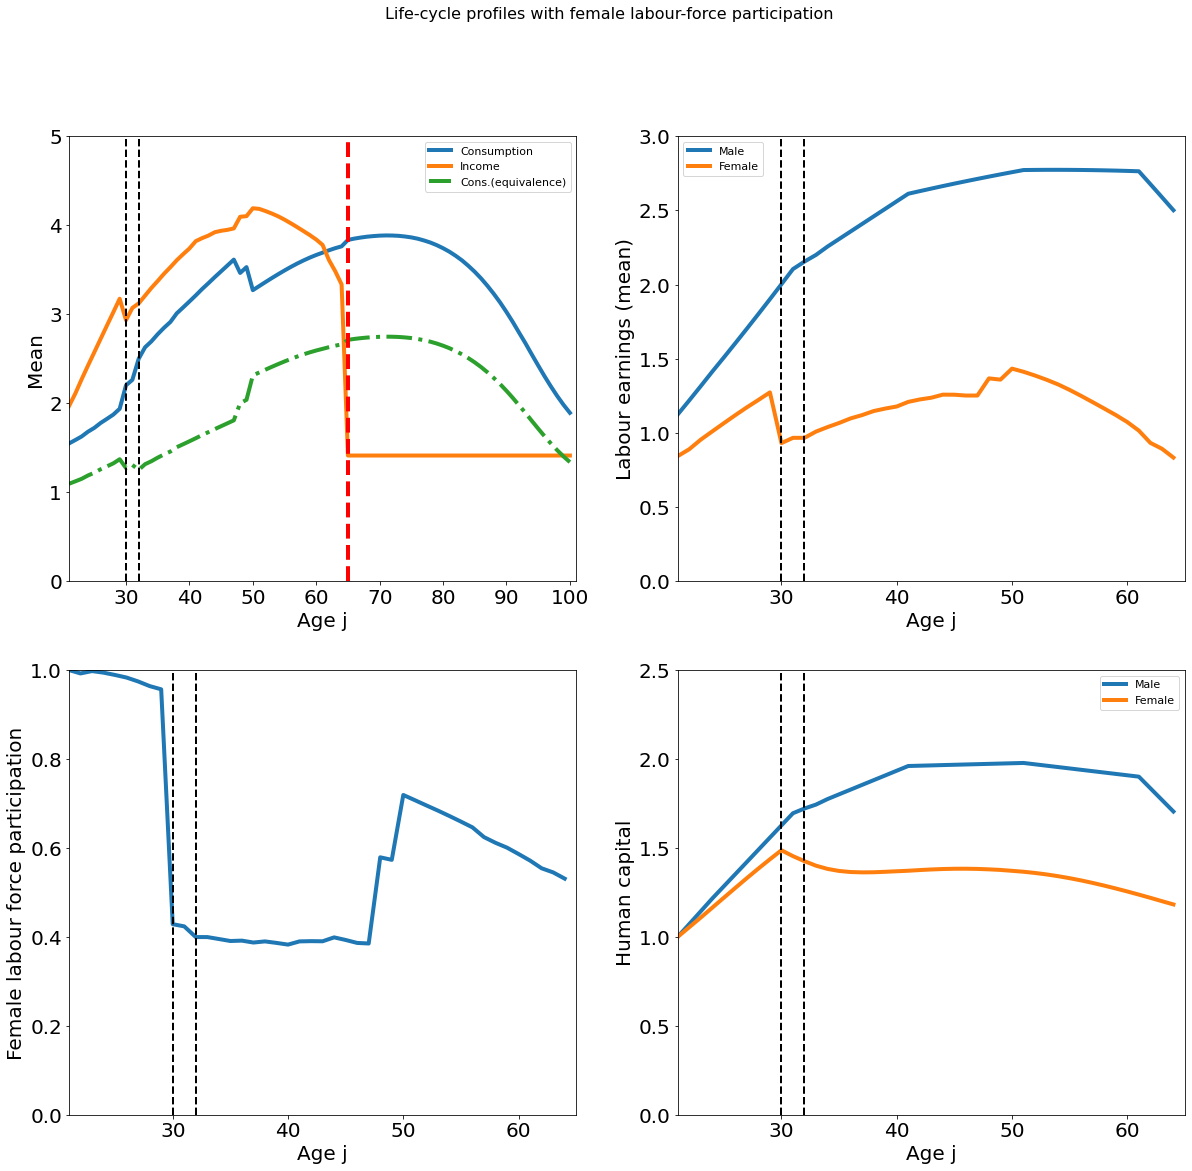

In [4]:
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams.update({'font.size': 20})


fig1, ax1 = plt.subplots(2,2,figsize = (20,18))
fig1.suptitle('Life-cycle profiles with female labour-force participation',fontsize = '16')
age = np.arange(model.J) + 21

ax1[0,0].plot(age, model.c_coh, label = 'Consumption')
ax1[0,0].plot(age, model.ym_coh + model.yf_coh + model.pen, label = 'Income')
ax1[0,0].plot(age, model.c_coh/(2+model.nc)**0.5, linestyle = '-.', label = 'Cons.(equivalence)')
ax1[0,0].set_ylim(0,5)


ax1[0,1].plot(age[:model.JR-1], model.ym_coh[:model.JR-1], label = 'Male')
ax1[0,1].plot(age[:model.JR-1], model.yf_coh[:model.JR-1], label = 'Female')
ax1[0,1].set_ylim(0,3)

ax1[1,0].plot(age[:model.JR-1], model.l_coh[:model.JR-1])
ax1[1,0].set_ylim(0,1)



ax1[1,1].plot(age[:model.JR-1], model.eff[:model.JR-1], label = 'Male')
ax1[1,1].plot(age[:model.JR-1], model.h_coh[:model.JR-1], label = 'Female')
ax1[1,1].set_ylim(0,2.5)




ylabels1 = ['Mean','Labour earnings (mean)','Female labour force participation','Human capital']
ind = -1
for i in range(2):
    for j in range(2):
        ind += 1
        ax1[i,j].set_xlabel('Age j')
        ax1[i,j].set_ylabel(ylabels1[ind])
        
        for n in range(len(model.children)):
            if model.children[n] != 0:
                ax1[i,j].axvline(x = model.children[n], c = 'k', linestyle = '--', linewidth = '2')
        if i == 0 and j == 0:
            ax1[i,j].set_xlim(21, model.J + 21)
            ax1[i,j].axvline(x = model.JR + 20, c = 'r', linestyle = '--')
        else:
            ax1[i,j].set_xlim(21, model.JR + 20)
        if not (i == 1 and j == 0):
            ax1[i,j].legend(fontsize=11)

In [5]:
frac = np.zeros(model.J)
for j in range(model.J - 1):
    for i in range(model.NA):
        for ih in range(model.NH):
            for p in range(model.NP):
                for sm in range(model.NS):
                    for sf in range(model.NS):
                        if model.aplus[j,i,ih,p,sm,sf] < 1e-6:
                            frac[j] += model.Φ[j,i,ih,p,sm,sf]
                            
frac[-1] = 1

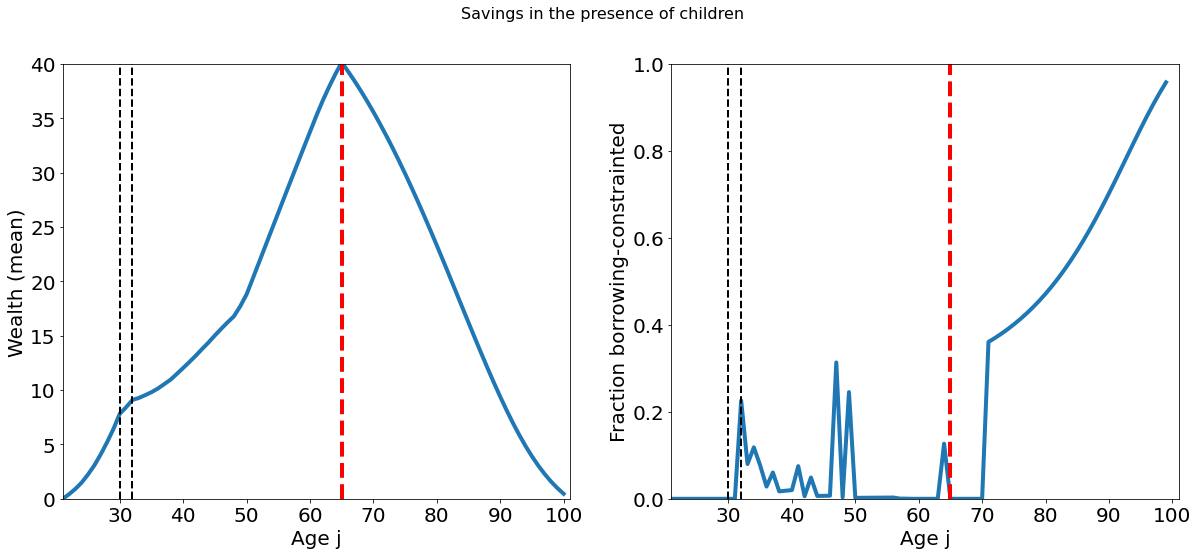

In [6]:
fig2, ax2 = plt.subplots(1,2, figsize = (20,8))
fig2.suptitle('Savings in the presence of children',fontsize = '16')

ax2[0].plot(age, model.a_coh)
ax2[0].set_ylim(0,40)
ax2[1].plot(age[:-1], frac[:-1])
ax2[1].set_ylim(0,1)

ylabels2 = ['Wealth (mean)', 'Fraction borrowing-constrainted']

for i in range(2):
    ax2[i].set_xlabel('Age j')
    ax2[i].set_ylabel(ylabels2[i])
    for n in range(len(model.children)):
        if model.children[n] != 0:
            ax2[i].axvline(x = model.children[n], c = 'k', linestyle = '--', linewidth = '2')
    ax2[i].set_xlim(21, model.J + 21)
    ax2[i].axvline(x = model.JR + 20, c = 'r', linestyle = '--')

In [7]:
%time model2 = LifeCycleFemale(NA = 15, NH = 7, children = np.concatenate(([23,25], np.zeros(8))), verbose = False)

Wall time: 2min 25s


In [8]:
%time model3 = LifeCycleFemale(NA = 15, NH = 7, children = np.zeros(10), verbose = False)

Wall time: 2min 27s


In [9]:
%time model4 = LifeCycleFemale(NA = 15, NH = 7, children = np.concatenate(([27,30,33], np.zeros(7))), verbose = False)

Wall time: 2min 26s


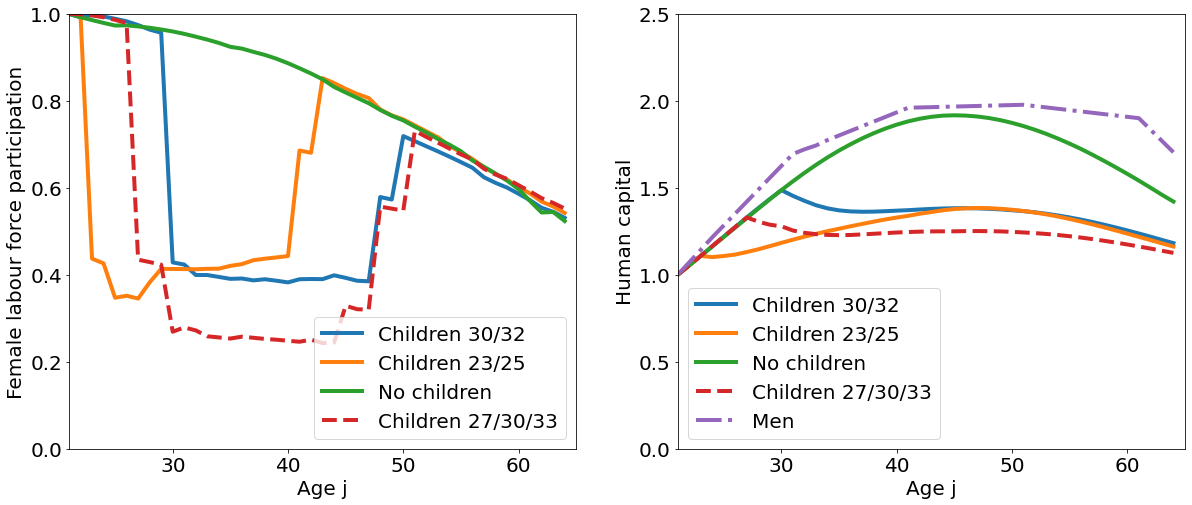

In [10]:
fig3, ax3 = plt.subplots(1, 2,figsize = (20,8))

ax3[0].plot(age[:model.JR-1], model.l_coh[:model.JR-1], label = 'Children 30/32')
ax3[0].plot(age[:model2.JR-1], model2.l_coh[:model2.JR-1], label = 'Children 23/25')
ax3[0].plot(age[:model3.JR-1], model3.l_coh[:model3.JR-1], label = 'No children')
ax3[0].plot(age[:model4.JR-1], model4.l_coh[:model4.JR-1], linestyle = '--', label = 'Children 27/30/33')
ax3[0].set_ylim(0,1)


ax3[1].plot(age[:model.JR-1], model.h_coh[:model.JR-1], label = 'Children 30/32')
ax3[1].plot(age[:model2.JR-1], model2.h_coh[:model2.JR-1], label = 'Children 23/25')
ax3[1].plot(age[:model3.JR-1], model3.h_coh[:model3.JR-1], label = 'No children')
ax3[1].plot(age[:model4.JR-1], model4.h_coh[:model4.JR-1], linestyle = '--', label = 'Children 27/30/33')
ax3[1].plot(age[:model.JR-1], model.eff[:model.JR-1], linestyle = '-.', label = 'Men')

ax3[1].set_ylim(0,2.5)


ylabel3 = ['Female labour force participation','Human capital']
for i in range(2):
    ax3[i].legend()
    ax3[i].set_xlabel('Age j')
    ax3[i].set_ylabel(ylabel3[i])
    ax3[i].set_xlim(21, model.JR + 20)